In [844]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, RobustScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Configuraciones
%matplotlib inline
sns.set_theme(style="darkgrid", palette="tab10", font_scale=1.2)

# Repositorio del notebook
# https://github.com/asier-ortiz/module-2-notebooks/blob/main/diamonds_asier_ortiz.ipynb

# Información del dataset
# Ref. https://www.kaggle.com/datasets/shivam2503/diamonds

## **Funciones Helper**
Aquí se encuentran las funciones auxiliares utilizadas en este notebook. Estas funciones permiten realizar tareas específicas de manera más ordenada y modular.

In [845]:
def introduce_nulls(df, percentage):
    """
    Introduce valores nulos aleatorios en un DataFrame hasta alcanzar un porcentaje deseado.

    :param df: DataFrame original al que se introducirán valores nulos.
    :param percentage: Porcentaje de valores nulos a introducir, entre 0 y 1.
    :return: DataFrame con valores nulos introducidos.
    """
    df = df.copy()
    total_cells = df.size
    current_nulls = df.isnull().sum().sum()
    target_nulls = int(total_cells * percentage)
    additional_nulls = max(0, target_nulls - current_nulls)

    if additional_nulls == 0:
        return df

    for _ in range(additional_nulls):
        row = np.random.randint(0, df.shape[0])
        col = np.random.randint(0, df.shape[1])
        df.iat[row, col] = np.nan

    return df


def introduce_invalid_values(df, categorical_cols, numeric_cols, cat_invalid_values, percentage):
    """
    Introduce valores inválidos en un DataFrame:
    - En columnas categóricas: introduce valores como '???', 'INVALID', '   '
    - En columnas numéricas: convierte algunos valores a string y otros a negativos

    :param df: DataFrame original
    :param categorical_cols: Lista de columnas categóricas
    :param numeric_cols: Lista de columnas numéricas
    :param cat_invalid_values: Lista de valores inválidos para categóricas
    :param percentage: Porcentaje de valores inválidos a introducir
    :return: DataFrame modificado con valores inválidos
    """
    df = df.copy()

    # Introducir valores inválidos en columnas categóricas
    for col in categorical_cols:
        n_invalids = int(len(df) * percentage)
        invalid_indices = df[col].dropna().sample(n=n_invalids, random_state=42).index
        df.loc[invalid_indices, col] = np.random.choice(cat_invalid_values, size=n_invalids)

    # Introducir valores inválidos en columnas numéricas (strings y negativos)
    for col in numeric_cols:
        n_invalids = int(len(df) * percentage)
        invalid_indices_str = df[col].dropna().sample(n=n_invalids, random_state=42).index
        invalid_indices_neg = df[col].dropna().sample(n=n_invalids, random_state=43).index

        # Convertir temporalmente la columna a tipo object para permitir la asignación de strings
        df[col] = df[col].astype('object')

        # Introducir valores en string
        df.loc[invalid_indices_str, col] = df.loc[invalid_indices_str, col].astype(str)

        # Introducir valores negativos
        df.loc[invalid_indices_neg, col] = df.loc[invalid_indices_neg, col].astype(float) * -1

        # Convertir de nuevo la columna a su tipo original (float)
        df[col] = pd.to_numeric(df[col], errors='coerce')

    return df


def calculate_metrics(preprocessor_name, X_train, X_test, y_train, y_test):
    """
    Evalúa modelos de clasificación con múltiples métricas y validación cruzada.

    Retorna:
    - DataFrame con métricas de cada modelo.
    """

    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'KNN': KNeighborsClassifier(n_neighbors=5),
        'SVM': SVC(kernel='rbf')
    }

    results = []

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calcular métricas de clasificación
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average="weighted", zero_division=0)
        recall = recall_score(y_test, y_pred, average="weighted", zero_division=0)
        f1 = f1_score(y_test, y_pred, average="weighted")
        jaccard = jaccard_score(y_test, y_pred, average="weighted")

        # Validación cruzada
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
        mean_cv = cv_scores.mean()
        std_cv = cv_scores.std()

        # Guardar resultados en lista
        results.append({
            "Modelo": model_name,
            "Preprocesado": preprocessor_name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1,
            "Jaccard": jaccard,
            "Mean CV Accuracy": mean_cv,
            "Std CV Accuracy": std_cv
        })

    # Convertir resultados a DataFrame
    df_results = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
    return df_results


## **Paso 1: Carga, exploración y limpieza inicial de datos**

### 1. Importación del dataset
- Importación del dataset `diamonds.csv` para su análisis.
- Introducción de valores nulos e inválidos en un **1%** de los datos para simular problemas reales y poner a prueba estrategias de limpieza.

### 2. Identificación de tipos de datos
- Identificación de las columnas categóricas y numéricas.
- Definición de listas de valores inválidos para cada tipo de columna (ej., `"???"`, `"RANDOM STRING"`, valores negativos o strings en columnas numéricas).

### 3. Exploración inicial del dataset
- Revisión de la estructura del dataset con `info()`, lo que permite conocer el número de valores no nulos por columna y los tipos de datos.
- Visualización de las primeras filas con `head()`.
- Generación de estadísticas descriptivas con `describe()` para evaluar la distribución de las variables numéricas y las frecuencias de las categóricas.
- Identificación de valores nulos y filas duplicadas.

### 4. Limpieza de valores erróneos
- Reemplazo de valores inválidos en columnas categóricas con `NaN`, eliminando datos que no pertenecían a los valores esperados.
- Conversión de todas las columnas numéricas a tipo `float64` para corregir posibles errores de formato.
- Transformación de los valores negativos en positivos, ya que en este contexto no existen longitudes o precios negativos.
- **Reemplazo de valores `0` por `NaN` en `carat`, `x`, `y` y `z`**, ya que en la realidad estas dimensiones no pueden ser **0**.

### 5. Eliminación de datos con exceso de valores nulos
- Eliminación de **columnas** con más del **50%** de valores nulos, ya que contienen demasiada información faltante y podrían no aportar valor al análisis.
- Eliminación de **filas** con más del **50%** de valores nulos, ya que tienen información incompleta y podrían afectar la calidad del modelo.

### 6. Conteo final de valores nulos
- Impresión del número de valores nulos restantes en cada columna para evaluar el impacto de la limpieza y determinar qué variables necesitarán imputación en el siguiente paso.

In [846]:
# Cargar el dataset con pandas
diamonds = pd.read_csv('data/diamonds.csv')

In [847]:
# Identificar columnas categóricas y numéricas
categorical_cols = diamonds.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = diamonds.select_dtypes(include=['number']).columns.tolist()

In [848]:
# Introducir valores inválidos en el 1% del dataset
diamonds = introduce_invalid_values(diamonds, categorical_cols, numeric_cols, ['?!?', 'RANDOM STRING', '   '],
                                    percentage=0.01)

In [849]:
# Introducir valores nulos en el 1% del dataset
diamonds = introduce_nulls(diamonds, 0.01)

In [850]:
# Mostrar información del dataset después de la introducción de valores nulos e inválidos
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53357 non-null  float64
 1   cut      53368 non-null  object 
 2   color    53407 non-null  object 
 3   clarity  53426 non-null  object 
 4   depth    53398 non-null  float64
 5   table    53397 non-null  float64
 6   price    53387 non-null  float64
 7   x        53426 non-null  float64
 8   y        53443 non-null  float64
 9   z        53420 non-null  float64
dtypes: float64(7), object(3)
memory usage: 4.1+ MB


In [851]:
# Mostrar las 5 primeras filas
diamonds.head(5)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326.0,3.95,3.98,2.43
1,0.21,Premium,E,NaN,59.8,61.0,326.0,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327.0,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334.0,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335.0,NaN,4.35,2.75


In [852]:
# Estadísticas descriptivas
diamonds.describe(include='all')

,carat,cut,color,clarity,depth,table,price,x,y,z
count,53357.000000,53368,53407,53426,53398.000000,53397.000000,53387.000000,53426.000000,53443.000000,53420.000000
unique,NaN,8,10,11,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Ideal,G,SI1,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,21095,11079,12824,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.782251,NaN,NaN,NaN,60.512205,56.311192,3857.820574,5.617740,5.619633,3.467719
std,0.500224,NaN,NaN,NaN,12.383110,11.637350,4064.546770,1.598248,1.614576,0.997307
min,-2.660000,NaN,NaN,NaN,-70.500000,-65.000000,-18565.000000,-8.870000,-8.830000,-5.580000
25%,0.390000,NaN,NaN,NaN,61.000000,56.000000,932.000000,4.690000,4.700000,2.900000
50%,0.700000,NaN,NaN,NaN,61.800000,57.000000,2374.000000,5.690000,5.700000,3.520000
75%,1.040000,NaN,NaN,NaN,62.500000,59.000000,5287.500000,6.530000,6.530000,4.030000


In [853]:
# Conteo de valores nulos por columna
print(diamonds.isnull().sum())

carat      583
cut        572
color      533
clarity    514
depth      542
table      543
price      553
x          514
y          497
z          520
dtype: int64


In [854]:
# Filas duplicadas en el dataset
diamonds[diamonds.duplicated()]

,carat,cut,color,clarity,depth,table,price,x,y,z
1005,0.79,Ideal,G,SI1,62.3,57.0,2898.0,5.90,5.85,3.66
1006,0.79,Ideal,G,SI1,62.3,57.0,2898.0,5.90,5.85,3.66
1007,0.79,Ideal,G,SI1,62.3,57.0,2898.0,5.90,5.85,3.66
1008,0.79,Ideal,G,SI1,62.3,57.0,2898.0,5.90,5.85,3.66
2025,1.52,Good,E,I1,57.3,58.0,3105.0,7.53,7.42,4.28
...,...,...,...,...,...,...,...,...,...,...
47296,0.30,Good,J,VS1,63.4,57.0,394.0,4.23,4.26,2.69
47969,0.52,Ideal,D,VS2,61.8,55.0,1919.0,5.19,5.16,3.20
49557,0.71,Good,F,SI2,64.1,60.0,2130.0,0.00,0.00,0.00
50079,0.51,Ideal,F,VVS2,61.2,56.0,2203.0,5.19,5.17,3.17


In [855]:
# No elimino duplicados porque pueden representar diamantes legítimos con las mismas características.
# diamonds.drop_duplicates(inplace=True)

In [856]:
# Definir los valores válidos para las columnas categóricas
valid_categorical_values = {
    'cut': ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'],
    'color': ['D', 'E', 'F', 'G', 'H', 'I', 'J'],
    'clarity': ['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1']
}

# Reemplazar valores incorrectos en cada columna categórica
for col, valid_vals in valid_categorical_values.items():
    diamonds.loc[~diamonds[col].isin(valid_vals), col] = np.nan

In [857]:
# Convertir todas las columnas numéricas a tipo numérico (corrige posibles conversiones fallidas)
diamonds[numeric_cols] = diamonds[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Convertir valores negativos en positivos
for col in numeric_cols:
    diamonds[col] = diamonds[col].abs()

# Reemplazar valores 0 con NaN en carat, x, y, z
columns_to_fix_zero_values = ['carat', 'x', 'y', 'z']
diamonds[columns_to_fix_zero_values] = diamonds[columns_to_fix_zero_values].replace(0, np.nan)

In [858]:
#  Eliminar columnas con más del 50% de valores nulos
threshold_col = 0.5
null_percent = diamonds.isnull().mean()
cols_to_drop = null_percent[null_percent > threshold_col].index
diamonds.drop(columns=cols_to_drop, inplace=True)
print(f"Columnas eliminadas por tener más del {threshold_col * 100}% de valores nulos:")
print(list(cols_to_drop))

Columnas eliminadas por tener más del 50.0% de valores nulos:
[]


In [859]:
# Eliminar filas con más del 50% de valores nulos
threshold_row = 0.5
row_null_percent = diamonds.isnull().mean(axis=1)
diamonds = diamonds[row_null_percent <= threshold_row]
print(
    f"Filas eliminadas por tener más del {threshold_row * 100}% de valores nulos: {row_null_percent[row_null_percent > threshold_row].count()}")

Filas eliminadas por tener más del 50.0% de valores nulos: 0


In [860]:
# Conteo de valores nulos por columna después de la limpieza
print("Valores nulos después de la limpieza:")
print(diamonds.isnull().sum())

Valores nulos después de la limpieza:
carat       583
cut        1108
color      1067
clarity    1046
depth       542
table       543
price       553
x           522
y           504
z           540
dtype: int64


## **Paso 2: Exploración mediante EDA y tratamiento de valores nulos**

### 1. Exploración previa a la imputación
Antes de imputar valores nulos, se analizaron las variables para comprender su distribución y detectar posibles sesgos:

- **Histogramas** de variables numéricas para visualizar su distribución y la presencia de valores extremos.
- **Gráficos de barras** para analizar la frecuencia de valores en variables categóricas (`cut`, `color`, `clarity`).
- **Conteo de valores nulos** en cada columna para identificar qué variables requieren imputación.
- **Matriz de correlación** para evaluar la relación entre variables numéricas y detectar patrones útiles en la imputación.

### 2. Imputación de valores nulos
Se aplicaron diferentes estrategias según la naturaleza de cada variable:

- **`carat`** → Media global para mantener su distribución original.
- **`cut`, `color`, `clarity`** → Moda, preservando la proporción de categorías y evitando sesgos en la variable objetivo (`cut`).
- **`depth`** → Cálculo basado en `x`, `y`, `z` cuando es posible; media global en otros casos.
- **`table`** → Mediana para reducir el impacto de valores extremos.
- **`price`** → Mediana, evitando la influencia de valores atípicos.
- **`x`, `y`** → KNNImputer (5 Neighbors), debido a su fuerte correlación.
- **`z`** → Cálculo basado en `depth`, `x` e `y`, asegurando coherencia geométrica.

### 3. Evaluación posterior a la imputación
Después de la imputación, se realizaron verificaciones para garantizar la coherencia de los datos:

- **Revisión de tipos de datos** para confirmar que numéricas y categóricas se mantuvieron correctamente.
- **Conteo de valores nulos** para validar que la imputación se aplicó sin errores.

### 4. Visualización después de la imputación
Para evaluar el impacto de la imputación, se generaron:

- **Histogramas** para verificar cambios en la distribución de variables numéricas.
- **Gráficos de barras** para comprobar si las proporciones en variables categóricas se mantuvieron.
- **Boxplots y scatterplots** para analizar la relación entre `cut` y otras variables (`price`, `carat`, `x`, `y`).
- **Matriz de correlación** posterior a la imputación para validar la coherencia de las relaciones entre variables.
- **Pairplot** con `cut` como `hue`, para observar patrones visuales en múltiples variables.


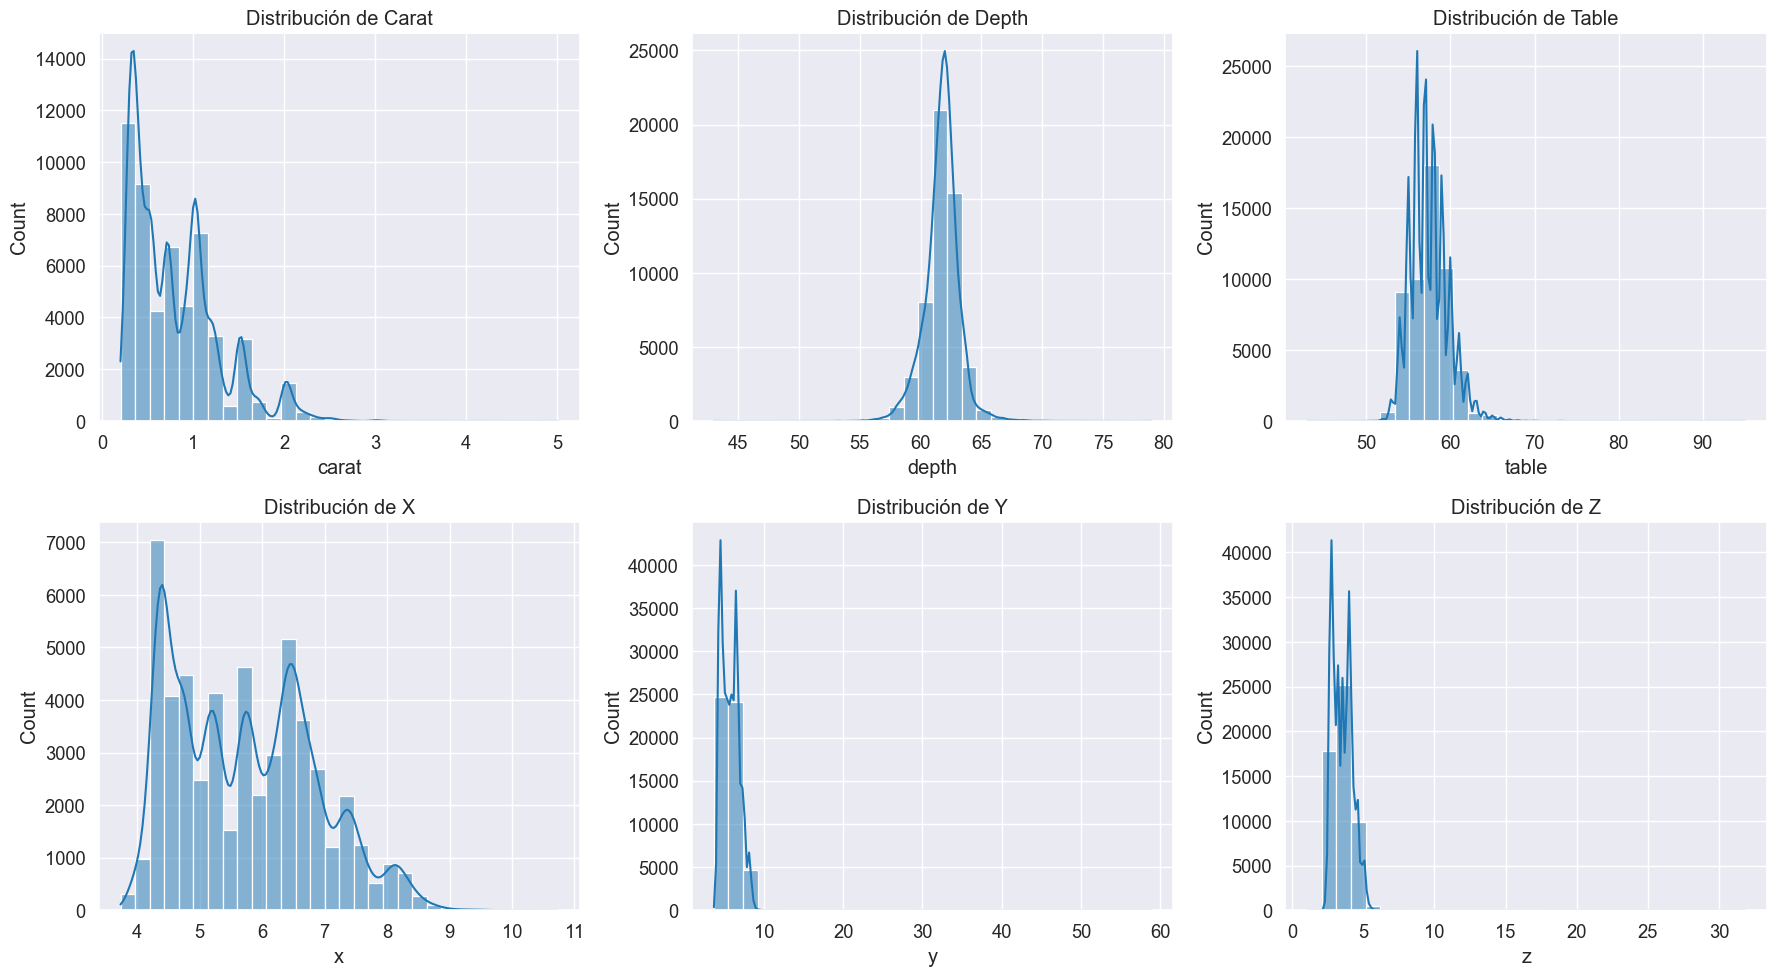

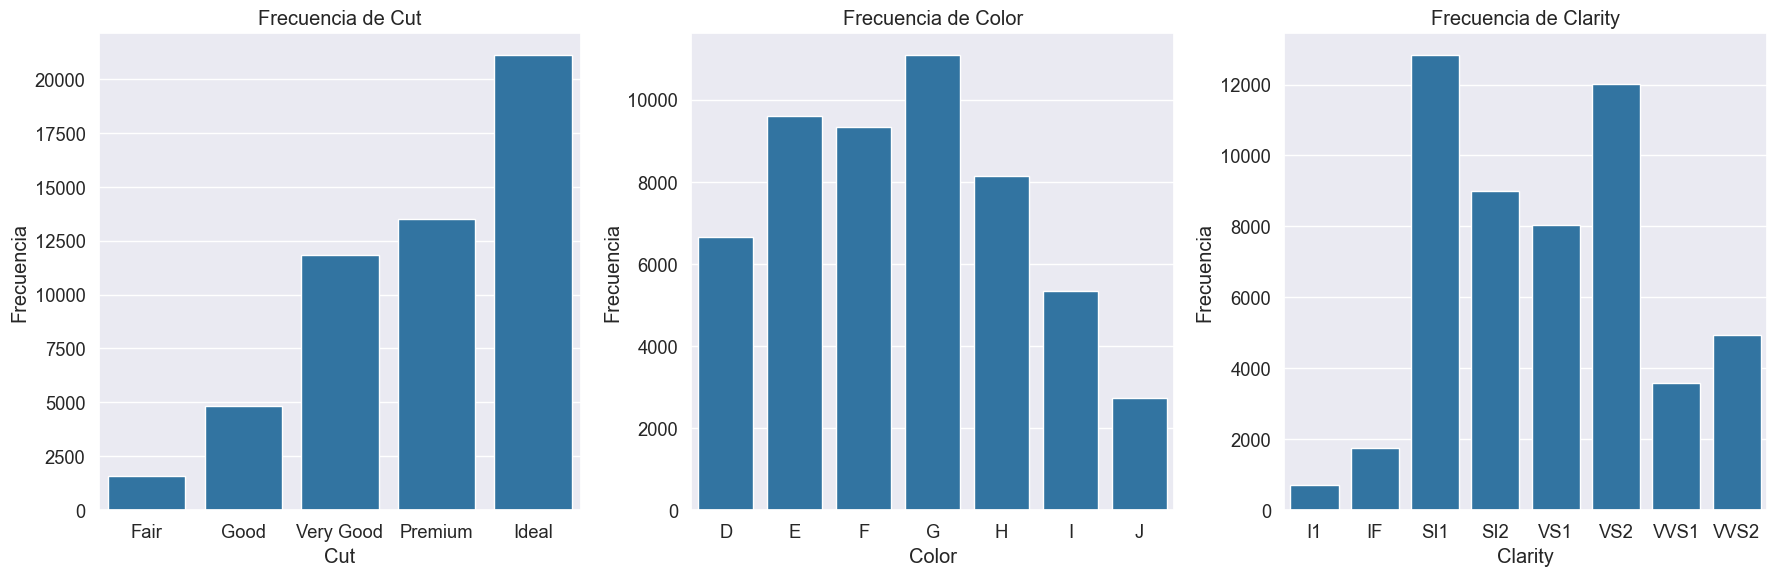

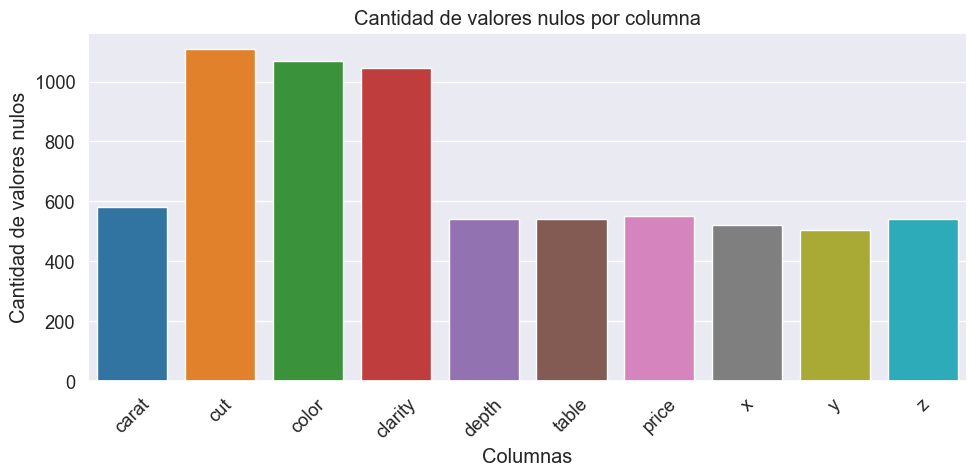

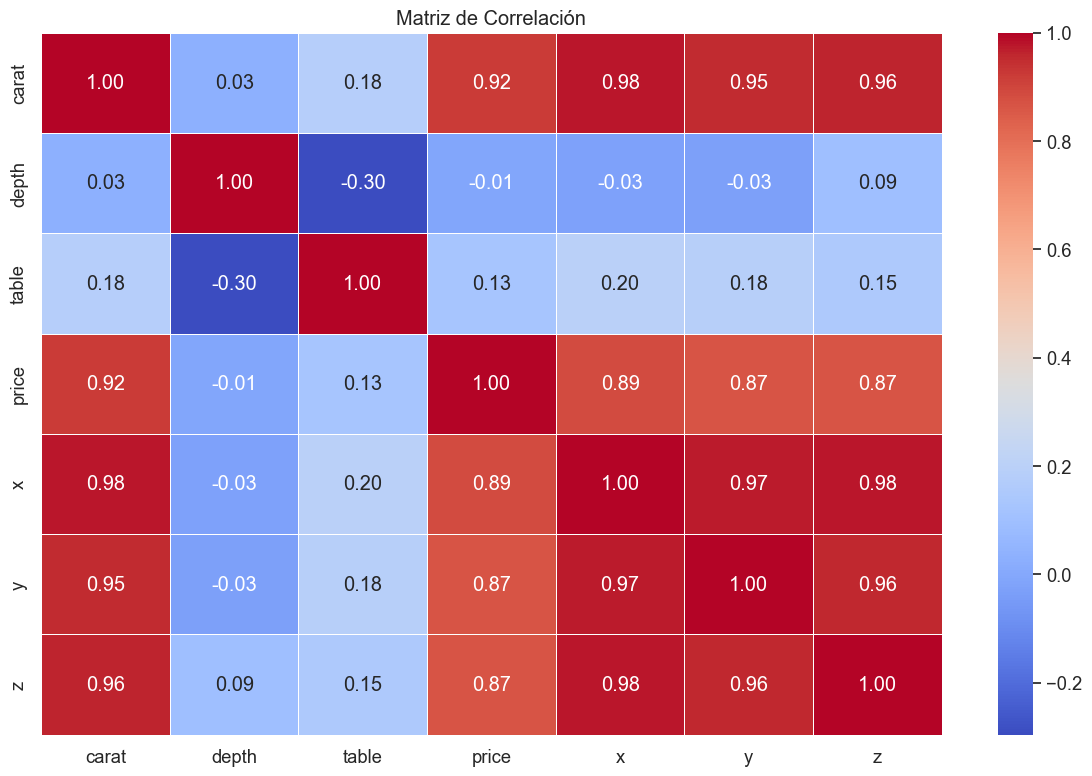

In [861]:
# Exploración previa a la imputación

#  Distribuciones de variables numéricas antes de la imputación
_, axes = plt.subplots(2, 3, figsize=(18, 10))

sns.histplot(diamonds['carat'].dropna(), kde=True, bins=30, ax=axes[0, 0])
axes[0, 0].set(title='Distribución de Carat')

sns.histplot(diamonds['depth'].dropna(), kde=True, bins=30, ax=axes[0, 1])
axes[0, 1].set(title='Distribución de Depth')

sns.histplot(diamonds['table'].dropna(), kde=True, bins=30, ax=axes[0, 2])
axes[0, 2].set(title='Distribución de Table')

# TODO Mostrar también Price

sns.histplot(diamonds['x'].dropna(), kde=True, bins=30, ax=axes[1, 0])
axes[1, 0].set(title='Distribución de X')

sns.histplot(diamonds['y'].dropna(), kde=True, bins=30, ax=axes[1, 1])
axes[1, 1].set(title='Distribución de Y')

sns.histplot(diamonds['z'].dropna(), kde=True, bins=30, ax=axes[1, 2])
axes[1, 2].set(title='Distribución de Z')

plt.tight_layout()
plt.show()

# Distribución de variables categóricas antes de la imputación
_, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.countplot(x=diamonds['cut'], order=['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'], ax=axes[0])
axes[0].set(title='Frecuencia de Cut', xlabel='Cut', ylabel='Frecuencia')

sns.countplot(x=diamonds['color'], order=sorted(diamonds['color'].dropna().unique()), ax=axes[1])
axes[1].set(title='Frecuencia de Color', xlabel='Color', ylabel='Frecuencia')

sns.countplot(x=diamonds['clarity'], order=sorted(diamonds['clarity'].dropna().unique()), ax=axes[2])
axes[2].set(title='Frecuencia de Clarity', xlabel='Clarity', ylabel='Frecuencia')

plt.tight_layout()
plt.show()

# Conteo de valores nulos antes de la imputación
plt.figure(figsize=(10, 5))

sns.barplot(x=diamonds.isnull().sum().index, y=diamonds.isnull().sum().values, hue=diamonds.isnull().sum().index,
            palette="tab10", legend=False)

plt.title("Cantidad de valores nulos por columna")
plt.xlabel("Columnas")
plt.ylabel("Cantidad de valores nulos")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Matriz de correlación antes de la imputación
plt.figure(figsize=(12, 8))
corr = diamonds.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación")
plt.tight_layout()
plt.show()

In [862]:
# Imputación de valores nulos

# Carat: Se imputa con la media global porque es una variable numérica sin sesgo fuerte
imputer_carat = SimpleImputer(strategy="mean")
diamonds[['carat']] = imputer_carat.fit_transform(diamonds[['carat']])

# Variables categóricas: Se imputan con la moda porque mantiene la distribución
imputer_cat = SimpleImputer(strategy="most_frequent")
diamonds[['cut', 'color', 'clarity']] = imputer_cat.fit_transform(diamonds[['cut', 'color', 'clarity']])

# Depth: Se recalcula usando X, Y y Z cuando es posible. Si no, se usa la media global
mask = diamonds[['x', 'y', 'z']].notna().all(axis=1)
diamonds.loc[mask, 'depth'] = (diamonds.loc[mask, 'z'] / diamonds.loc[mask, ['x', 'y']].mean(axis=1)) * 100
diamonds['depth'] = diamonds['depth'].fillna(diamonds['depth'].mean())

# Table: Se imputa con la mediana para evitar sesgo por valores extremos
imputer_table = SimpleImputer(strategy="median")
diamonds[['table']] = imputer_table.fit_transform(diamonds[['table']])

# Price: Se usa la mediana para evitar que valores extremos distorsionen la imputación.
diamonds['price'] = diamonds['price'].fillna(diamonds['price'].median())

# X e Y: Se usa KNNImputer porque están fuertemente correlacionadas
knn_imputer = KNNImputer(n_neighbors=5)
diamonds[['x', 'y']] = knn_imputer.fit_transform(diamonds[['x', 'y']])

#  Z: Se calcula en función de depth, x e y
diamonds['z'] = diamonds['z'].fillna((diamonds['depth'] / 100) * ((diamonds['x'] + diamonds['y']) / 2))

In [863]:
# Asegurar que los tipos de datos sean correctos
diamonds = diamonds.astype({
    'carat': 'float64',
    'depth': 'float64',
    'table': 'float64',
    'price': 'int64',
    'x': 'float64',
    'y': 'float64',
    'z': 'float64',
    'cut': 'category',
    'color': 'category',
    'clarity': 'category'
})

print(diamonds.dtypes)

carat       float64
cut        category
color      category
clarity    category
depth       float64
table       float64
price         int64
x           float64
y           float64
z           float64
dtype: object


In [864]:
# Mostrar conteo de valores nulos después de la imputación
print("Valores nulos después de la imputación:")
print(diamonds.isnull().sum())

Valores nulos después de la imputación:
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64


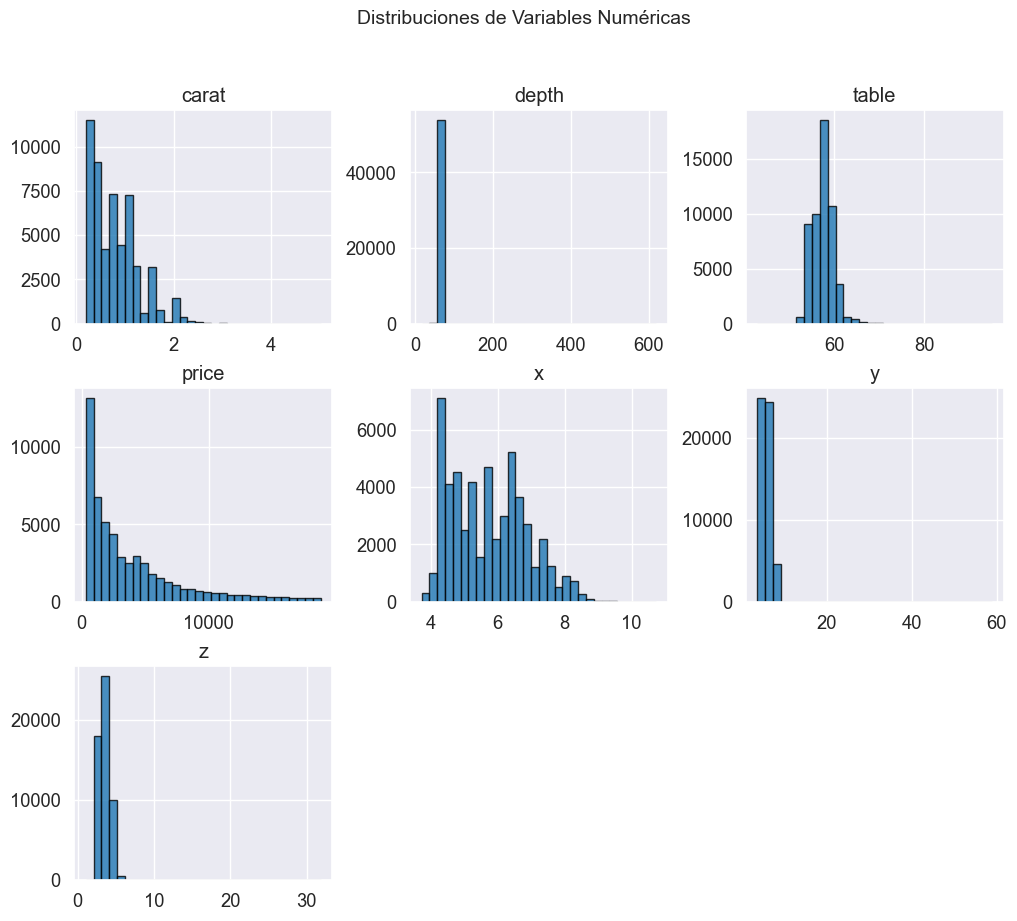

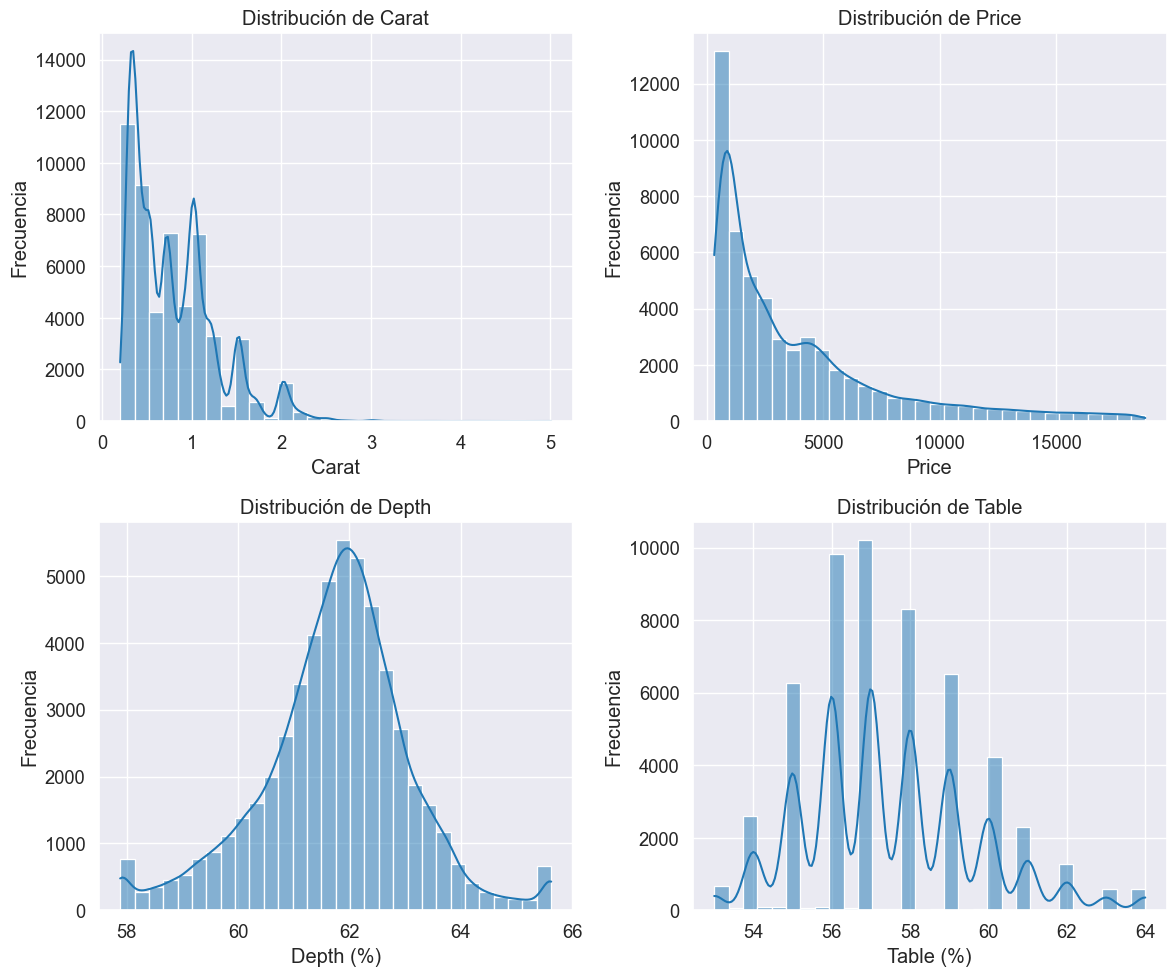

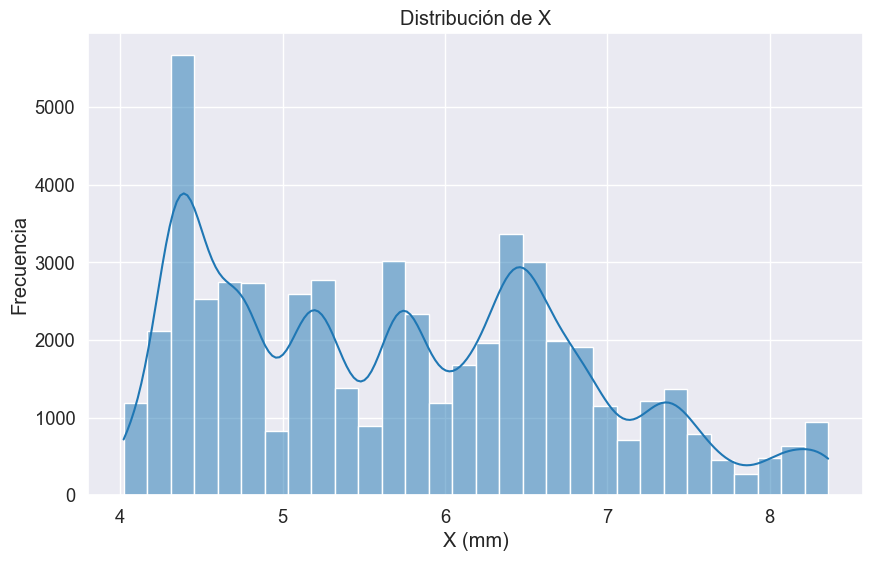

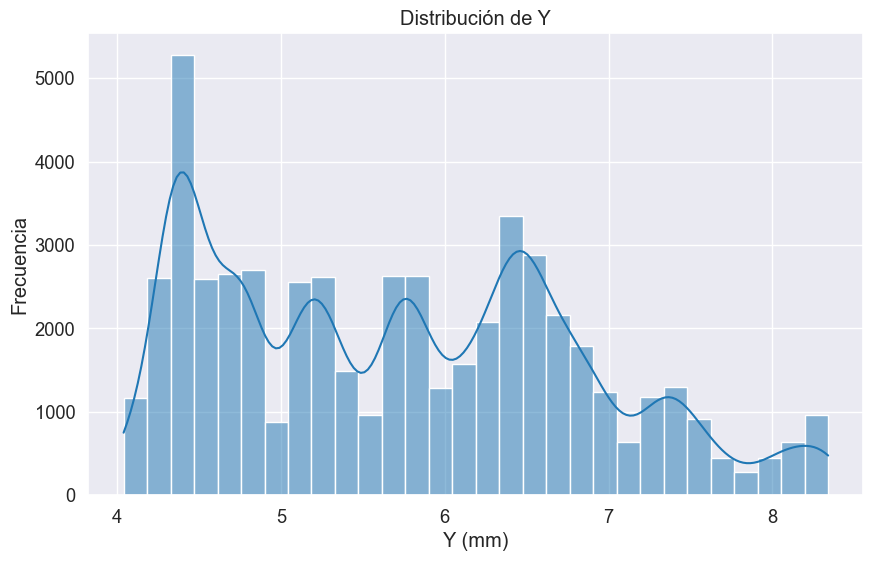

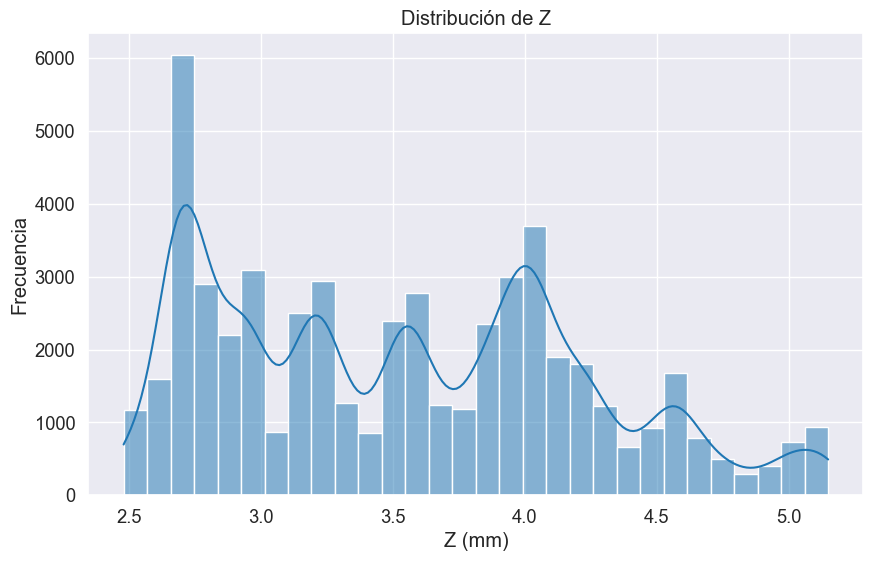

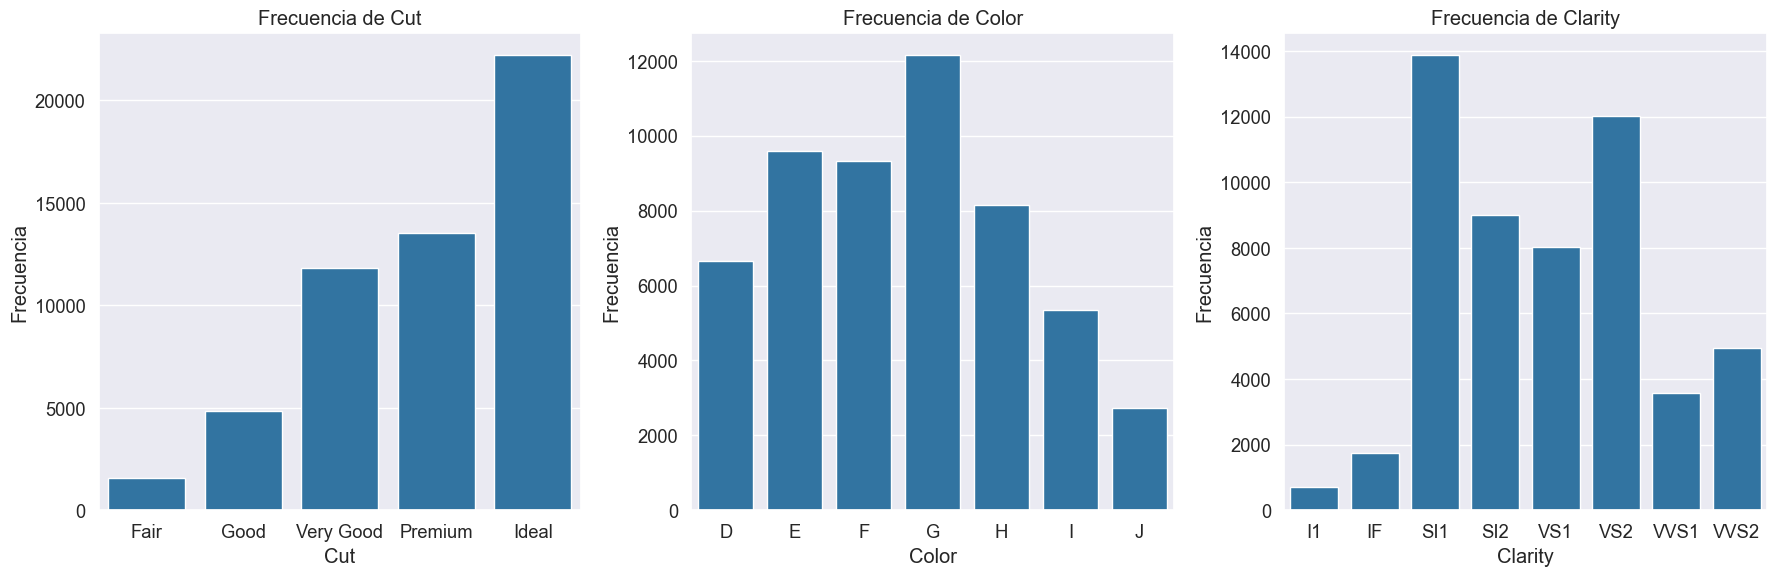

In [865]:
# UNIVARIANTES

# Histogramas con Pandas
diamonds.hist(figsize=(12, 10), bins=30, edgecolor="black", alpha=0.8)
plt.suptitle("Distribuciones de Variables Numéricas", fontsize=14)
plt.show()

# Histogramas con Seaborn
_, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.histplot(diamonds['carat'], kde=True, bins=30, ax=axes[0, 0])
axes[0, 0].set(title='Distribución de Carat', xlabel='Carat', ylabel='Frecuencia')

sns.histplot(diamonds['price'], kde=True, bins=30, ax=axes[0, 1])
axes[0, 1].set(title='Distribución de Price', xlabel='Price', ylabel='Frecuencia')

sns.histplot(diamonds['depth'].clip(diamonds['depth'].quantile(0.01), diamonds['depth'].quantile(0.99)), kde=True,
             bins=30, ax=axes[1, 0])
axes[1, 0].set(title='Distribución de Depth', xlabel='Depth (%)', ylabel='Frecuencia')

sns.histplot(diamonds['table'].clip(diamonds['table'].quantile(0.01), diamonds['table'].quantile(0.99)), kde=True,
             bins=30, ax=axes[1, 1])
axes[1, 1].set(title='Distribución de Table', xlabel='Table (%)', ylabel='Frecuencia')

plt.tight_layout()
plt.show()

# Histogramas de dimensiones físicas (x, y, z)
for dim in ['x', 'y', 'z']:
    _, ax = plt.subplots(figsize=(10, 6))
    sns.histplot(diamonds[dim].clip(diamonds[dim].quantile(0.01), diamonds[dim].quantile(0.99)), kde=True, bins=30,
                 ax=ax)
    ax.set(title=f'Distribución de {dim.upper()}', xlabel=f'{dim.upper()} (mm)', ylabel='Frecuencia')
    plt.show()

# Gráficos de barras para variables categóricas
_, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.countplot(x=diamonds['cut'], order=['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'], ax=axes[0])
axes[0].set(title='Frecuencia de Cut', xlabel='Cut', ylabel='Frecuencia')

sns.countplot(x=diamonds['color'], order=sorted(diamonds['color'].dropna().unique()), ax=axes[1])
axes[1].set(title='Frecuencia de Color', xlabel='Color', ylabel='Frecuencia')

sns.countplot(x=diamonds['clarity'], order=sorted(diamonds['clarity'].dropna().unique()), ax=axes[2])
axes[2].set(title='Frecuencia de Clarity', xlabel='Clarity', ylabel='Frecuencia')

plt.tight_layout()
plt.show()

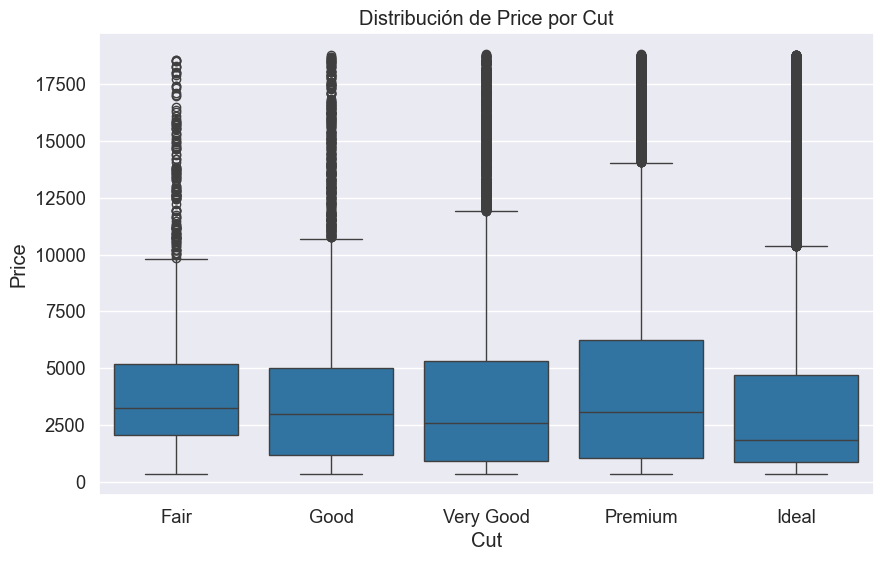

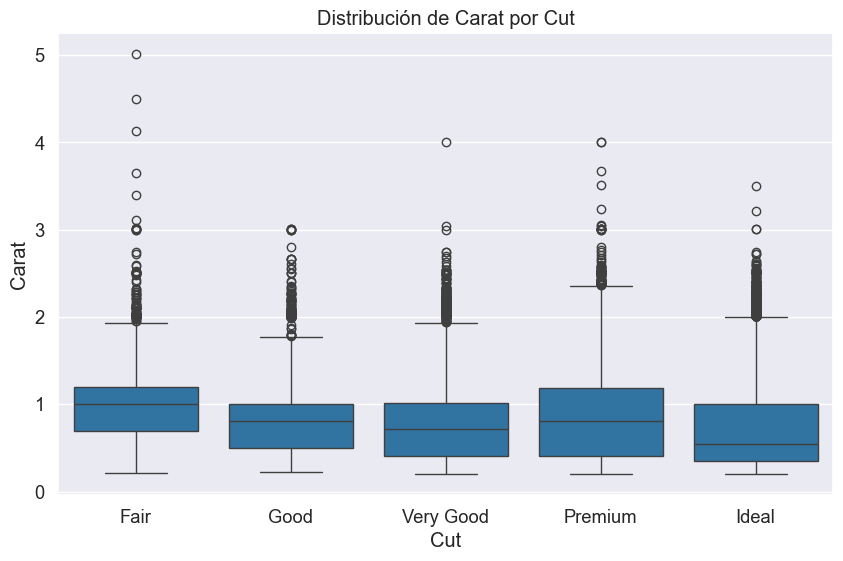

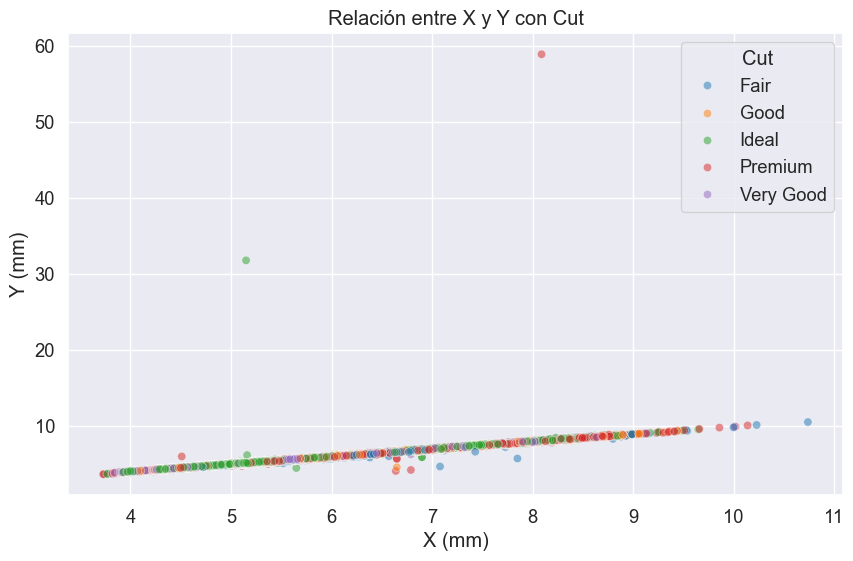

In [866]:
# BIVARIANTES

# Relación entre cut y price
_, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='cut', y='price', data=diamonds, order=['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'], ax=ax)
ax.set(title='Distribución de Price por Cut', xlabel='Cut', ylabel='Price')
plt.show()

# Relación entre cut y carat
_, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='cut', y='carat', data=diamonds, order=['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'], ax=ax)
ax.set(title='Distribución de Carat por Cut', xlabel='Cut', ylabel='Carat')
plt.show()

# Relación entre X, Y y cut
_, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=diamonds['x'], y=diamonds['y'], hue=diamonds['cut'], alpha=0.5, ax=ax)
ax.set(title='Relación entre X y Y con Cut', xlabel='X (mm)', ylabel='Y (mm)')
plt.legend(title='Cut', bbox_to_anchor=(1, 1))
plt.show()

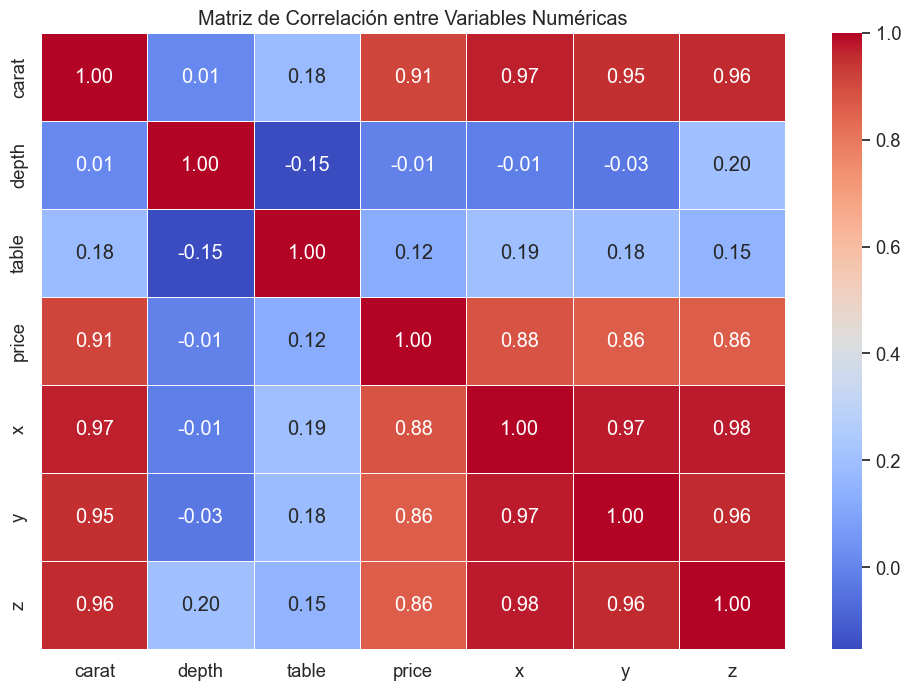

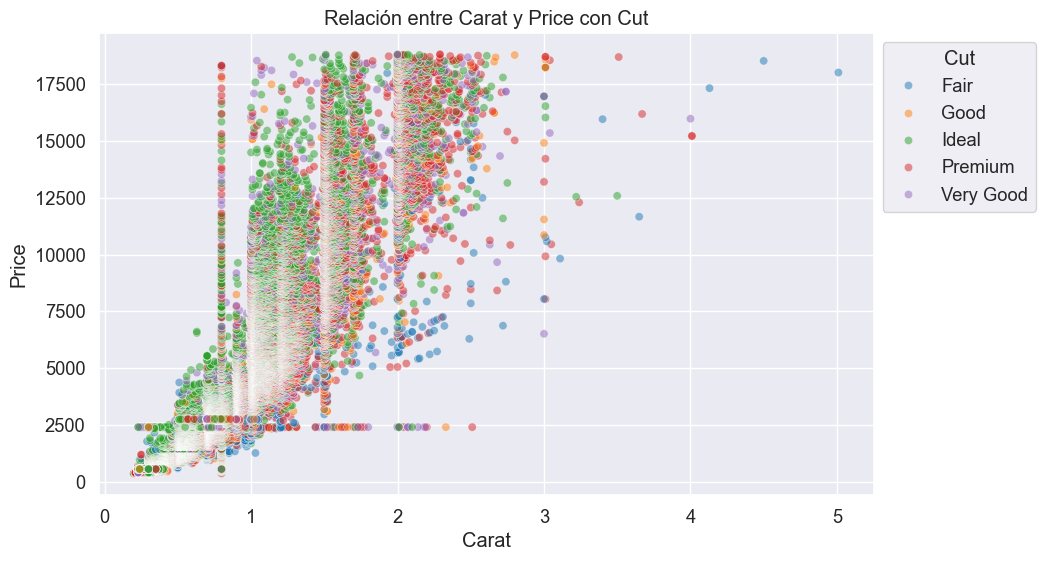

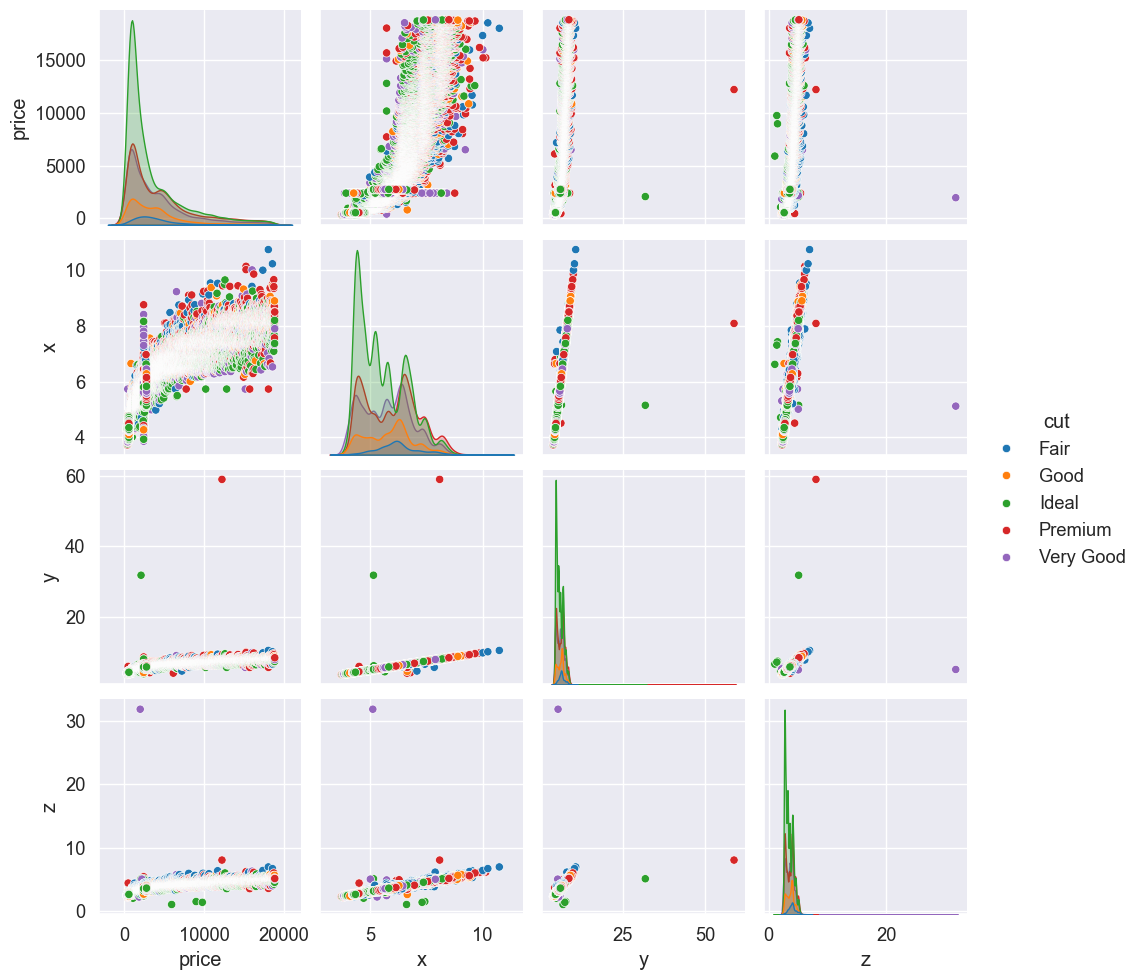

In [867]:
# MULTIVARIANTES

# Matriz de correlación entre variables numéricas
plt.figure(figsize=(12, 8))
corr = diamonds.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación entre Variables Numéricas")
plt.show()

# Relación entre carat, price y cut
_, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=diamonds['carat'], y=diamonds['price'], hue=diamonds['cut'], alpha=0.5, ax=ax)
ax.set(title="Relación entre Carat y Price con Cut", xlabel="Carat", ylabel="Price")
plt.legend(title="Cut", bbox_to_anchor=(1, 1))
plt.show()

# Pairplot con hue en cut
sns.pairplot(diamonds[['price', 'cut', 'x', 'y', 'z']], hue='cut')
plt.show()

## **Paso 3: Preprocesamiento de Datos**

Para mejorar la calidad de los datos antes del modelado, en este paso se aplican diferentes técnicas de preprocesamiento: **creación de nuevas características, codificación de variables categóricas, tratamiento de outliers, escalado de variables numéricas y transformación de distribuciones sesgadas**.

### 1. **Codificación de Variables Categóricas**
- Se aplica **`OrdinalEncoder`** a la variable objetivo `cut`, ya que sigue un orden lógico de calidad (de "Fair" a "Ideal").
- Se aplica **`OrdinalEncoder`** a las variables categóricas `color` y `clarity`, ya que también presentan un orden predefinido.

### 2. **Creación de Nuevas Características**
- Se generan dos nuevas variables basadas en propiedades geométricas del diamante para mejorar la predicción del `cut`:
  - **`depth_diff`**: Diferencia entre la profundidad real del diamante y el valor medio de `x` e `y`. Representa cuánto se desvía de un corte ideal.
  - **`length_width_ratio`**: Relación entre `x` e `y`, útil para evaluar la proporción del diamante, lo que puede influir en su percepción visual y simetría.
- Estas nuevas características están fundamentadas en criterios de evaluación de calidad de corte de diamantes.
  - **Referencia**: [GIA Diamond Cut Grade - Six Things to Know](https://4cs.gia.edu/en-us/blog/gia-diamond-cut-grade-six-things-to-know/)

### 3. **Análisis y Tratamiento de Outliers**
- Se visualizan los valores atípicos mediante **boxplots** y se calcula la asimetría de cada variable.
- Se emplean diferentes métodos para el tratamiento de outliers según la naturaleza de cada variable:
  - **IQR (Interquartile Range)**: Se eliminan outliers en `price`, `carat` y `length_width_ratio`, ya que presentan colas largas y sesgo positivo.
  - **Truncado (Winsorización)**: Se ajustan los valores extremos en `depth` y `depth_diff`, ya que su distribución es anormalmente sesgada.

### 4. **Escalado de Variables Numéricas**
- Se eligen diferentes escaladores en función de la presencia de outliers:
  - **`RobustScaler`**: Para `depth`, `price`, `carat` y `depth_diff`, ya que son sensibles a valores extremos.
  - **`StandardScaler`**: Para `x`, `y`, `z`, `table` y `length_width_ratio`, ya que presentan menos outliers y se benefician de una distribución normalizada.

### 5. **Transformaciones para Reducir Asimetría**
- Se aplican métodos de transformación para mejorar la distribución de variables con sesgo significativo:
  - **`QuantileTransformer`**: Se usa en `depth`, `y`, `depth_diff` y `length_width_ratio` debido a su alta asimetría.
  - **`PowerTransformer`**: Se aplica a `price`, `carat` y `z` para suavizar su distribución.

### 6. **Visualización del Preprocesamiento**
- Se generan gráficos antes y después de cada transformación para evaluar su impacto.
- Se revisa la asimetría y la cantidad de outliers restantes después del tratamiento.


In [868]:
# Separar X (variables predictoras) e y (variable objetivo)

# La variable target que queremos predecir es cut
y = diamonds['cut']

# Todas las demás variables son predictoras
X = diamonds.drop(columns=['cut'])

# Mostramos las dimensiones de los conjuntos resultantes para confirmar la separación
print("Dimensiones de X:", X.shape)
print("Dimensiones de y:", y.shape)

# División de datos en train y test. Entrenamiento del 80% y prueba del 20% de los datos para evitar el data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Mostramos las dimensiones de cada conjunto
print(f"Dimensiones de X_train: {X_train.shape}")
print(f"Dimensiones de X_test: {X_test.shape}")
print(f"Dimensiones de y_train: {y_train.shape}")
print(f"Dimensiones de y_test: {y_test.shape}")

Dimensiones de X: (53940, 9)
Dimensiones de y: (53940,)
Dimensiones de X_train: (43152, 9)
Dimensiones de X_test: (10788, 9)
Dimensiones de y_train: (43152,)
Dimensiones de y_test: (10788,)


In [869]:
# Creación de nuevas características

# Diferencia con valores ideales de profundidad:
# La profundidad influye directamente en la cantidad de luz reflejada por el diamante. Si es demasiado alta o baja, puede afectar el brillo y la apariencia
# Fórmula ~> depth_diff = depth - ((x + y) / 2)
X_train['depth_diff'] = X_train['depth'] - ((X_train['x'] + X_train['y']) / 2)
X_test['depth_diff'] = X_test['depth'] - ((X_test['x'] + X_test['y']) / 2)

# Proporción largo-ancho
# Una proporción adecuada entre largo y ancho es clave para la simetría y la apariencia del diamante. Un diamante mal proporcionado puede reflejar menos luz o parecer asimétrico
# Fórmula ~> length_width_ratio = x / y
X_train['length_width_ratio'] = X_train['x'] / X_train['y']
X_test['length_width_ratio'] = X_test['x'] / X_test['y']

# Ref. https://4cs.gia.edu/en-us/blog/gia-diamond-cut-grade-six-things-to-know/

# Confirmar que las nuevas características se han añadido correctamente
print("\nPrimeras filas con nuevas características:")
display(X_train.head(5))


Primeras filas con nuevas características:


,carat,color,clarity,depth,table,price,x,y,z,depth_diff,length_width_ratio
26496,2.31,J,VVS1,62.093436,58.0,16100,8.49,8.42,5.25,53.638436,1.008314
37026,0.33,G,VVS2,62.954545,57.0,965,4.42,4.38,2.77,58.554545,1.009132
15670,1.18,G,SI1,60.761347,58.0,6286,6.81,6.85,4.15,53.931347,0.994161
23551,1.51,F,SI1,60.875513,61.0,11560,7.30,7.32,4.45,53.565513,0.997268
7666,1.01,G,SI1,61.297889,60.0,4271,6.41,6.38,3.92,54.902889,1.004702


In [870]:
# Encoding de variables categóricas

# La variable objetivo cut tiene un orden lógico, por lo que usaremos OrdinalEncoder
# Ref. "cut quality of the cut (Fair, Good, Very Good, Premium, Ideal)"
ordinal_mapping_cut = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
y_train_encoded = y_train.map(ordinal_mapping_cut)
y_test_encoded = y_test.map(ordinal_mapping_cut)

# Tanto color como clarity, variables predictoras, tienen un orden definido. Por lo que también aplicamos OrdinalEncoder
# Ref. "color diamond colour, from J (worst) to D (best)"
ordinal_mapping_color = {'D': 0, 'E': 1, 'F': 2, 'G': 3, 'H': 4, 'I': 5, 'J': 6}
# Ref. "clarity a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))"
ordinal_mapping_clarity = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}

X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

X_train_encoded['color'] = X_train_encoded['color'].map(ordinal_mapping_color)
X_test_encoded['color'] = X_test_encoded['color'].map(ordinal_mapping_color)

X_train_encoded['clarity'] = X_train_encoded['clarity'].map(ordinal_mapping_clarity)
X_test_encoded['clarity'] = X_test_encoded['clarity'].map(ordinal_mapping_clarity)

# Muestro los resultados del encoding
print("\nPrimeras filas de X_test_encoded:")
display(X_test_encoded.head(5))

print("\nPrimeras filas de X_train_encoded:")
display(X_train_encoded.head(5))


Primeras filas de X_test_encoded:


,carat,color,clarity,depth,table,price,x,y,z,depth_diff,length_width_ratio
3548,0.76,1,4,62.063086,58.0,3415,5.84,5.89,3.64,56.198086,0.991511
24827,1.51,2,3,61.758691,57.0,13221,7.39,7.28,4.53,54.423691,1.015110
52320,0.50,1,6,60.096618,56.0,2495,5.16,5.19,3.11,54.921618,0.994220
53688,0.82,3,2,63.052544,52.0,2716,6.02,5.97,3.78,57.057544,1.008375
24202,1.11,0,5,62.282691,56.0,12390,6.59,6.64,4.12,55.667691,0.992470



Primeras filas de X_train_encoded:


,carat,color,clarity,depth,table,price,x,y,z,depth_diff,length_width_ratio
26496,2.31,6,6,62.093436,58.0,16100,8.49,8.42,5.25,53.638436,1.008314
37026,0.33,3,5,62.954545,57.0,965,4.42,4.38,2.77,58.554545,1.009132
15670,1.18,3,2,60.761347,58.0,6286,6.81,6.85,4.15,53.931347,0.994161
23551,1.51,2,2,60.875513,61.0,11560,7.30,7.32,4.45,53.565513,0.997268
7666,1.01,3,2,61.297889,60.0,4271,6.41,6.38,3.92,54.902889,1.004702


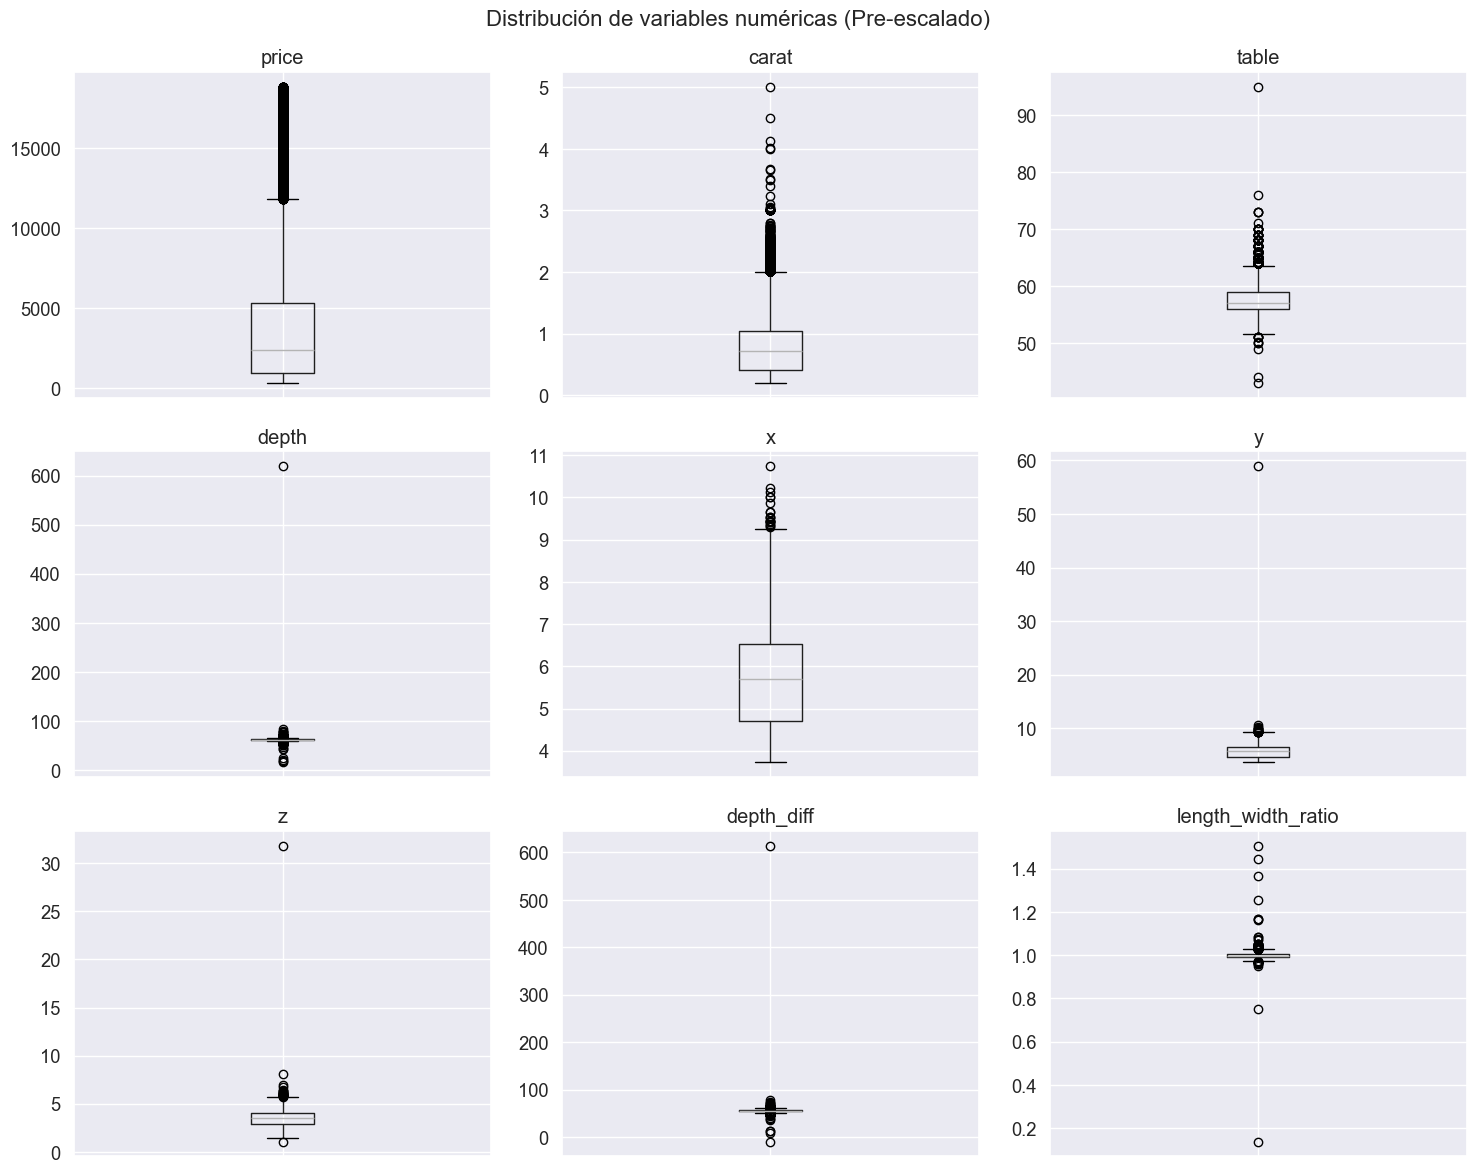

Asimetría de las variables numéricas:
 depth                 138.027960
depth_diff            112.043100
y                       2.697979
z                       1.857669
price                   1.625323
carat                   1.125050
table                   0.814207
x                       0.396673
length_width_ratio     -6.598288
dtype: float64

Cantidad de outliers detectados por columna:
 carat                 1500
depth                 2157
table                  479
price                 2891
x                       20
y                       18
z                       25
depth_diff             897
length_width_ratio     128
dtype: int64


In [871]:
# Análisis de outliers antes del escalado

numerical_cols = ['price', 'carat', 'table', 'depth', 'x', 'y', 'z', 'depth_diff', 'length_width_ratio']

# Boxplots para visualizar outliers en las variables numéricas
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
fig.suptitle("Distribución de variables numéricas (Pre-escalado)", fontsize=16)

for ax, col in zip(axes.flatten(), numerical_cols):
    X_train_encoded[[col]].boxplot(ax=ax)
    ax.set_title(col)
    ax.set_xticklabels([])

plt.tight_layout(rect=(0, 0, 1, 1))
plt.show()

# Cálculo de la asimetría de las variables numéricas
X_train_num = X_train_encoded.select_dtypes(include=['number'])
skewness = X_train_num.skew().sort_values(ascending=False)
print("Asimetría de las variables numéricas:\n", skewness)

# Detección de outliers con IQR Valle Tukey
Q1 = X_train_num.quantile(0.25)
Q3 = X_train_num.quantile(0.75)
IQR = Q3 - Q1

# Conteo de valores que están fuera del rango permitido
outliers = ((X_train_num < (Q1 - 1.5 * IQR)) | (X_train_num > (Q3 + 1.5 * IQR))).sum()
print("\nCantidad de outliers detectados por columna:\n", outliers)

In [872]:
# Interpretación de los resultados:
#
# ⚠️ Nota para Alan:
# En cada ejecución del notebook, los valores de asimetría y detección de outliers pueden variar debido a la aleatoriedad en la introducción
# de valores nulos e inválidos. Esto afecta la distribución de los datos y, en consecuencia, los resultados de este análisis.
# Para solucionar este problema, debería haber fijado un "random_state" en cada paso donde se introducen valores aleatorios.
# Sin embargo, los resultados que presento a continuación corresponden a la ejecución en la que realicé el análisis.
#
# 1. Análisis de Asimetría:
#     - La variable depth tiene una asimetría negativa muy alta, lo que indica que la mayoría de los valores están agrupados en la parte superior con una cola larga a la izquierda (asimetría negativa)
#     - y, price y carat tienen una asimetría positiva, con valores concentrados en la parte baja y una cola larga a la derecha (asimetría positiva)
#     - depth_diff también presenta una asimetría extremadamente alta, lo que sugiere valores muy desviados del ideal
#     - length_width_ratio tiene una asimetría negativa pronunciada, indicando que la mayoría de los valores están en un rango bajo con algunos valores muy altos
#     - table, x y z presentan menor asimetría
#
# 2. Cantidad de Outliers:
#     - depth tiene más de 2_000 outliers ~> Truncar sus valores extremos
#     - price y carat tienen una cantidad significativa de valores atípicos ~> Aplicar eliminación mediante IQR
#     - depth_diff tiene casi 1_000 outliers, lo que indica que los valores extremos deben ajustarse ~> Truncar sus valores extremos
#     - length_width_ratio tiene menos outliers pero sigue siendo una cantidad relevante ~> Aplicar eliminación mediante IQR
#     - y, x, z tienen pocos outliers, por lo que no es necesario eliminarlos
#
# 3. Próximos pasos:
#     - Tratamiento de Outliers: Eliminación de valores extremos en price, carat y length_width_ratio con IQR, y truncado en depth y depth_diff
#     - Escalado: Usar RobustScaler para reducir el impacto de valores atípicos en price, carat y depth_diff
#     - Transformaciones: Aplicar QuantileTransformer y PowerTransformer para colunnas con alta y baja asimetría respectivamente

In [873]:
# Tratamiento de Outliers

# Filtrar sólo columnas numéricas
X_train_num = X_train_encoded.select_dtypes(include=['number']).copy()

# Columnas con outliers extremos
outlier_columns_iqr = ['price', 'carat', 'length_width_ratio']  # IQR
outlier_columns_clip = ['depth', 'depth_diff']  # Truncado

# Cálculo de IQR para price, carat y length_width_ratio
Q1 = X_train_num[outlier_columns_iqr].quantile(0.25)
Q3 = X_train_num[outlier_columns_iqr].quantile(0.75)
IQR = Q3 - Q1

# Aplico el filtro IQR para price, carat y length_width_ratio
filter_no_outliers = ~((X_train_num[outlier_columns_iqr] < (Q1 - 1.5 * IQR)) |
                       (X_train_num[outlier_columns_iqr] > (Q3 + 1.5 * IQR))).any(axis=1)

# Aplico el filtro para eliminar outliers en X
X_train_filtered = X_train_encoded[filter_no_outliers].copy()
# Aplico el filtro para eliminar outliers en y
y_train_filtered = y_train_encoded[
    filter_no_outliers].copy()  # Se eliminan las mismas filas en y para que coincida con X

# Aplico el truncado en depth y depth_diff
for col in outlier_columns_clip:
    lower_bound = X_train_filtered[col].quantile(0.01)
    upper_bound = X_train_filtered[col].quantile(0.99)
    X_train_filtered.loc[:, col] = np.clip(X_train_filtered[col], lower_bound, upper_bound)

# Muestro la cantidad de datos antes y después del tratamiento
print(f"Datos antes: {X_train_encoded.shape[0]}, Datos después: {X_train_filtered.shape[0]}")

Datos antes: 43152, Datos después: 39973


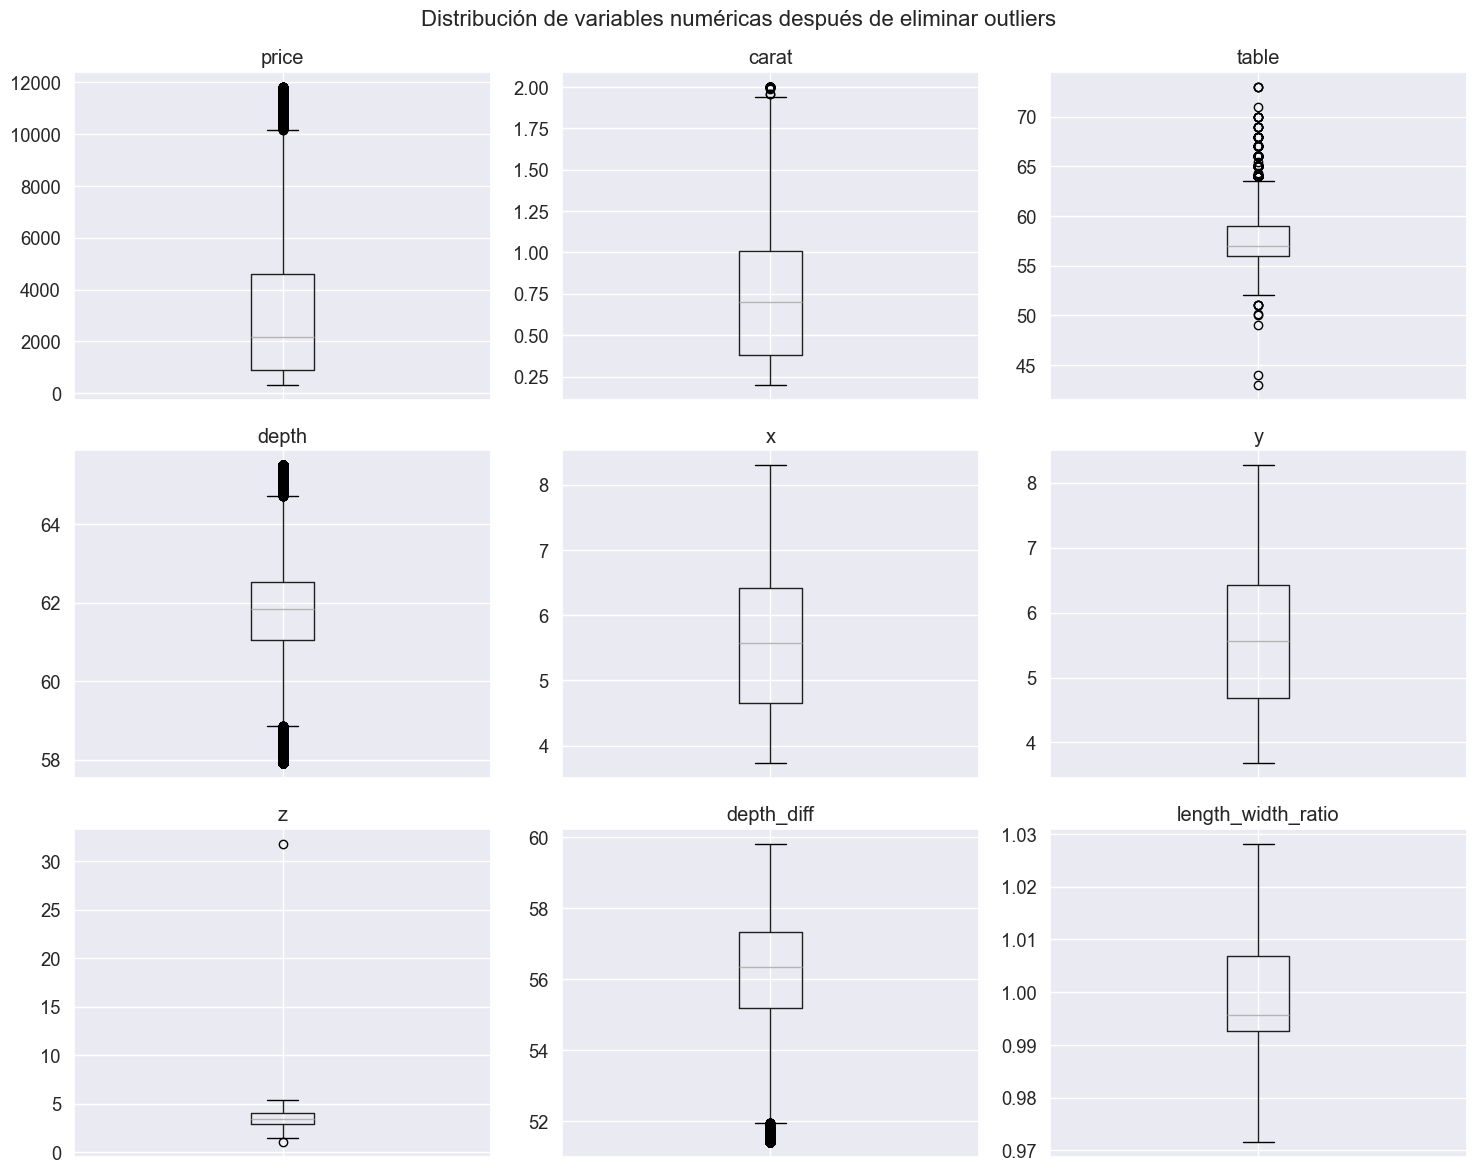

In [874]:
# Visualización con Boxplots después del tratamiento de outliers

numerical_cols = ['price', 'carat', 'table', 'depth', 'x', 'y', 'z', 'depth_diff', 'length_width_ratio']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
fig.suptitle("Distribución de variables numéricas después de eliminar outliers", fontsize=16)

for ax, col in zip(axes.flatten(), numerical_cols):
    X_train_filtered[[col]].boxplot(ax=ax)
    ax.set_title(col)
    ax.set_xticklabels([])

plt.tight_layout(rect=(0, 0, 1, 1))
plt.show()

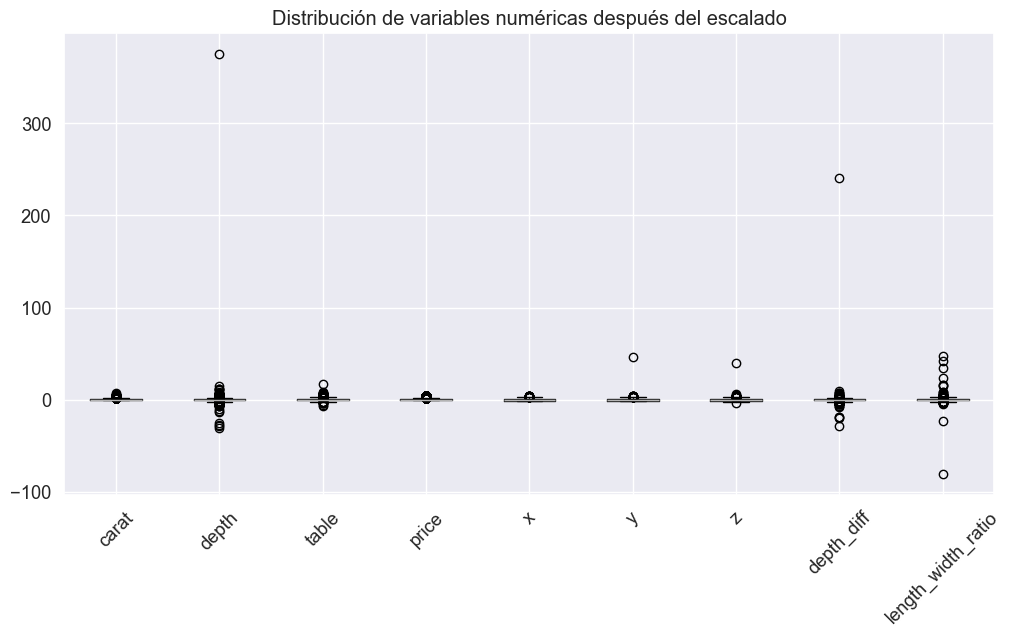

In [875]:
# Escalado de variables numéricas utilizando diferentes escaladores según outliers

# Todas las columnas numéricas
numerical_cols = X_train_encoded.select_dtypes(include=['number']).columns

# Categorizar variables según la cantidad de outliers detectados
high_outliers = ['depth', 'price', 'carat', 'depth_diff']
low_outliers = ['x', 'y', 'z', 'table', 'length_width_ratio']

# Crear una instancia para cada Scaler
scaler_robust = RobustScaler()
scaler_standard = StandardScaler()

X_train_scaled = X_train_encoded.copy()
X_test_scaled = X_test_encoded.copy()

# Aplico RobustScaler a las variables con muchos outliers
X_train_scaled[high_outliers] = scaler_robust.fit_transform(X_train_encoded[high_outliers])
X_test_scaled[high_outliers] = scaler_robust.transform(X_test_encoded[high_outliers])

# Aplico StandardScaler a las variables con menos outliers
X_train_scaled[low_outliers] = scaler_standard.fit_transform(X_train_encoded[low_outliers])
X_test_scaled[low_outliers] = scaler_standard.transform(X_test_encoded[low_outliers])

# Visualización del efecto del escalado
plt.figure(figsize=(12, 6))
X_train_scaled[numerical_cols].boxplot(rot=45)
plt.title("Distribución de variables numéricas después del escalado")
plt.show()

In [876]:
# Aplicación de Transformaciones para reducir la asimetría

# Ref. https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html

# Columnas con alta y baja asimetría
high_skew_cols = ['depth', 'y', 'depth_diff', 'length_width_ratio']  # Alta asimetría ~> uso QuantileTransformer
low_skew_cols = ['z', 'price', 'carat']  # Baja asimetría ~> uso PowerTransformer

# Instancio los Transformers
quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=42)
power_transformer = PowerTransformer()

X_train_transformed = X_train_scaled.copy()
X_test_transformed = X_test_scaled.copy()

# Aplico QuantileTransformer en variables con alta asimetría
X_train_transformed[high_skew_cols] = quantile_transformer.fit_transform(X_train_scaled[high_skew_cols])
X_test_transformed[high_skew_cols] = quantile_transformer.transform(X_test_scaled[high_skew_cols])

# Aplico PowerTransformer a variables con baja asimetría
X_train_transformed[low_skew_cols] = power_transformer.fit_transform(X_train_scaled[low_skew_cols])
X_test_transformed[low_skew_cols] = power_transformer.transform(X_test_scaled[low_skew_cols])

# Mustro los datos después la transformación
new_skewness = X_train_transformed.select_dtypes(include=['number']).skew().sort_values(ascending=False)
print("\nAsimetría después de la transformación:\n", new_skewness)

print("\nDatos después de la transformación de asimetría:")
print(X_train_transformed.head(5))


Asimetría después de la transformación:
 table                 0.814207
x                     0.396673
price                 0.240258
z                     0.147967
carat                 0.146455
y                     0.034224
length_width_ratio    0.010534
depth                 0.007200
depth_diff           -0.000127
dtype: float64

Datos después de la transformación de asimetría:
          carat color clarity     depth     table     price         x  \
26496  2.116283     6       6  0.237017  0.246230  1.849038  2.457765   
37026 -1.220623     3       5  1.045968 -0.203418 -0.974239 -1.172576   
15670  0.972611     3       2 -0.868678  0.246230  1.006794  0.959246   
23551  1.398504     2       2 -0.792258  1.595175  1.587202  1.396314   
7666   0.699414     3       2 -0.491646  1.145526  0.583518  0.602456   

              y         z  depth_diff  length_width_ratio  
26496  2.523755  2.067629   -1.273071            0.914276  
37026 -1.197193 -1.179176    1.585173            1.0596

## **Paso 4: Modelado y Evaluación de Clasificación**

En este paso, entrenamos y evaluamos varios modelos de clasificación para predecir la calidad del corte (`cut`). Para ello, comparamos el rendimiento de los modelos con y sin preprocesamiento.

### **1. Preparación de los Datos**
- **Sin preprocesamiento:** Aplicamos encoding ordinal a las variables categóricas y escalado con `StandardScaler`, pero sin eliminar outliers ni transformar distribuciones.
- **Con preprocesamiento:** Incluye encoding, escalado con técnicas avanzadas, eliminación de outliers y transformación de variables con alta asimetría.

### **2. Entrenamiento y Evaluación de Modelos**
Utilizamos la función `calculate_metrics()` para entrenar distintos modelos y calcular métricas clave como:
- **Accuracy**
- **Precision, Recall y F1-score**
- **Jaccard Score**
- **Validación cruzada (5 folds)**

### **3. Modelos Evaluados**
Se comparan los siguientes algoritmos de clasificación:
- **Regresión Logística**
- **Árbol de Decisión**
- **Random Forest**
- **Gradient Boosting**
- **K-Nearest Neighbors (KNN)**
- **SVM (Support Vector Machine)**

### **4. Comparación de Resultados**
- Se almacenan los resultados en un DataFrame y se ordenan por precisión.
- Se comparan modelos con y sin preprocesamiento para evaluar el impacto del tratamiento de datos.

In [877]:
# Modelado y evaluación

# Aplicp el mismo encoding a los datos sin preprocesar
X_train_no_prep = X_train.copy()
X_test_no_prep = X_test.copy()

X_train_no_prep['color'] = X_train_no_prep['color'].map(ordinal_mapping_color)
X_test_no_prep['color'] = X_test_no_prep['color'].map(ordinal_mapping_color)

X_train_no_prep['clarity'] = X_train_no_prep['clarity'].map(ordinal_mapping_clarity)
X_test_no_prep['clarity'] = X_test_no_prep['clarity'].map(ordinal_mapping_clarity)

# Escalo los datos sin preprocesar con StandardScaler
scaler_no_prep = StandardScaler()
X_train_no_prep_scaled = pd.DataFrame(scaler_no_prep.fit_transform(X_train_no_prep), columns=X_train_no_prep.columns)
X_test_no_prep_scaled = pd.DataFrame(scaler_no_prep.transform(X_test_no_prep), columns=X_test_no_prep.columns)

# La variable target ya está codificada previamente con OrdinalEncoder
y_train_no_prep = y_train_encoded
y_test_no_prep = y_test_encoded

# Evalúo los modelos sin preprocesamiento
df_results_no_prep = calculate_metrics("Sin Preprocesado", X_train_no_prep_scaled, X_test_no_prep_scaled,
                                       y_train_no_prep, y_test_no_prep)

# Evalúo modelos con preprocesamiento
df_results_prep = calculate_metrics("Con Preprocesado", X_train_transformed, X_test_transformed,
                                    y_train_encoded, y_test_encoded)

# Comparar y mostrar ambos resultados
df_comparative = pd.concat([df_results_no_prep, df_results_prep]).sort_values(by="Accuracy", ascending=False)
print("\nComparación de Modelos con y sin Preprocesamiento:")
display(df_comparative)



Comparación de Modelos con y sin Preprocesamiento:


,Modelo,Preprocesado,Accuracy,Precision,Recall,F1-score,Jaccard,Mean CV Accuracy,Std CV Accuracy
3,Gradient Boosting,Sin Preprocesado,0.794679,0.793627,0.794679,0.793061,0.664052,0.795189,0.003120
3,Gradient Boosting,Con Preprocesado,0.794123,0.792801,0.794123,0.792488,0.663287,0.795490,0.002981
2,Random Forest,Con Preprocesado,0.790971,0.788026,0.790971,0.788710,0.658136,0.790299,0.003916
2,Random Forest,Sin Preprocesado,0.790044,0.787147,0.790044,0.787870,0.657052,0.790994,0.004211
5,SVM,Sin Preprocesado,0.751761,0.749605,0.751761,0.748874,0.609473,0.752109,0.001621
5,SVM,Con Preprocesado,0.748053,0.743721,0.748053,0.744636,0.603815,0.749142,0.003757
1,Decision Tree,Con Preprocesado,0.712736,0.712224,0.712736,0.712462,0.560182,0.708287,0.003320
1,Decision Tree,Sin Preprocesado,0.711995,0.711220,0.711995,0.711578,0.558902,0.708102,0.003022
4,KNN,Sin Preprocesado,0.700315,0.691182,0.700315,0.694021,0.547955,0.701103,0.003358
4,KNN,Con Preprocesado,0.695495,0.689954,0.695495,0.691923,0.543302,0.694869,0.004801
